In [1]:
# Important libraries

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN
    

Using TensorFlow backend.


[INFO] Found 34 Faces!


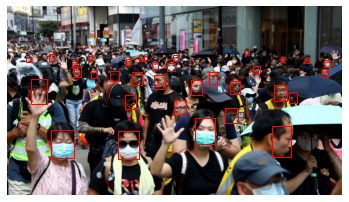

In [6]:
# https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/
path='/home/nice/Downloads/Mldata/group.jpg'

# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
    # load the image
    data = pyplot.imread(filename)
# plot the image
    pyplot.imshow(data)
# get the context for drawing boxes
    ax = pyplot.gca()
# plot each box
    for result in result_list:
# get coordinates
        x, y, width, height = result['box']
# create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
# draw the box
        ax.add_patch(rect)
# show the plot
        pyplot.axis('off')
    pyplot.show()

# load image from file
pixels = pyplot.imread(path)
# create the detector, using default weights
detector = MTCNN(
    weights_file= None,
    min_face_size= 4,
    steps_threshold= None,
    scale_factor= .9,
)

# detect faces in the image
faces = detector.detect_faces(pixels)
print("[INFO] Found {0} Faces!".format(len(faces)))

# display faces on the original image
draw_image_with_boxes(path, faces)

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

print("[INFO] loading images...")
imagePaths = list(paths.list_images('/home/nice/Downloads/Mldata/observations-master/experiements/data'))
data=[]
labels=[]
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [3]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [4]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

/home/nice/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [5]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Train for 34 steps, validate on 276 samples
Epoch 1/20
34/34 [==============================] - 71s 2s/step - loss: 0.7213 - accuracy: 0.6236 - val_loss: 0.2858 - val_accuracy: 0.9219
Epoch 2/20
34/34 [==============================] - 63s 2s/step - loss: 0.4528 - accuracy: 0.7996 - val_loss: 0.1601 - val_accuracy: 0.9688
Epoch 3/20
34/34 [==============================] - 59s 2s/step - loss: 0.3279 - accuracy: 0.8577 - val_loss: 0.1249 - val_accuracy: 0.9766
Epoch 4/20
34/34 [==============================] - 60s 2s/step - loss: 0.2649 - accuracy: 0.8943 - val_loss: 0.0857 - val_accuracy: 0.9805
Epoch 5/20
34/34 [==============================] - 59s 2s/step - loss: 0.2304 - accuracy: 0.9064 - val_loss: 0.0980 - val_accuracy: 0.9805
Epoch 6/20
34/34 [==============================] - 59s 2s/step - loss: 0.2021 - accuracy: 0.9316 - val_loss: 0.0764 - val_accuracy: 0.9844
Epoch 7/20
34/34 [==============================] - 58s 2s/step - 

In [6]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('mask.h5')

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.98       138
without_mask       0.99      0.98      0.98       138

    accuracy                           0.98       276
   macro avg       0.98      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276

[INFO] saving mask detector model...


In [2]:
model = load_model('mask.h5')

## for images

In [51]:
def draw_faces(filename, result_list):
# load the image
    data = pyplot.imread(filename)
    images_crop=[]
    # plot each face as a subplot
    for i in range(len(result_list)):
        # get coordinates
        x1, y1, width, height = result_list[i]['box']
        x2, y2 = x1 + width, y1 + height
        # define subplot
#         pyplot.subplot(1, len(result_list), i+1)
#         pyplot.axis('off')
        # plot face
#         pyplot.imshow(data[y1-2:y2+2, x1-2:x2+2])
        crop_image=data[y1-3:y2+3, x1-3:x2+3]
        images_crop.append(crop_image)
        
    for image in images_crop:
        face_1 = cv2.resize(image, (224, 224))
        face = img_to_array(face_1)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        # pass the face through the model to determine if the face
        # has a mask or not
        (mask, withoutMask) = model.predict(face)[0]
#         pyplot.subplot(figsize=(10,10))
        label = "Mask" if mask > withoutMask else "No Mask"
        # show the plot
        print(label)
        pyplot.imshow(face_1)
        pyplot.axis('off')
        pyplot.show()
        
        

[INFO] Found 12 Faces!
No Mask


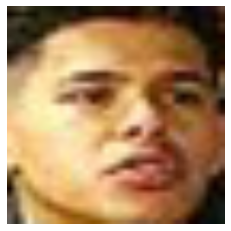

No Mask


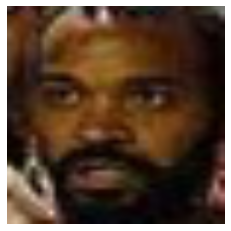

No Mask


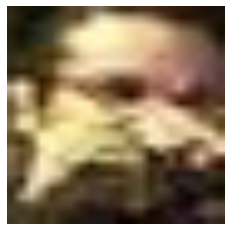

No Mask


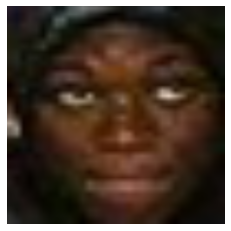

No Mask


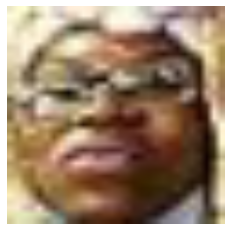

No Mask


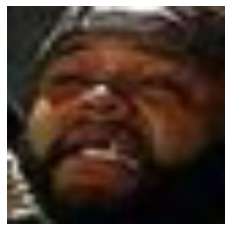

No Mask


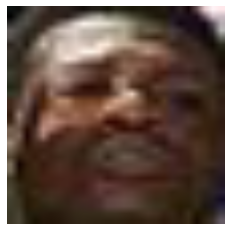

No Mask


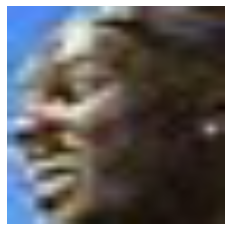

No Mask


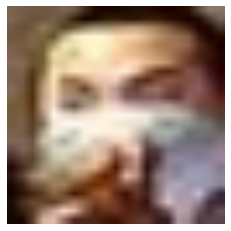

No Mask


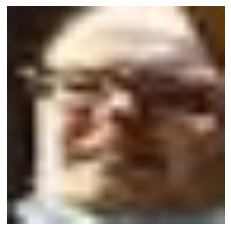

No Mask


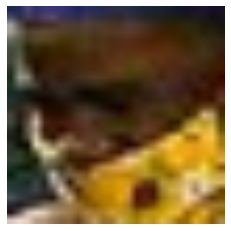

Mask


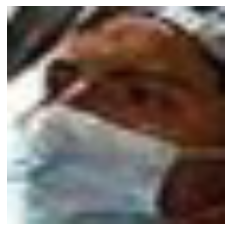

In [50]:
# load image from file

path='/home/nice/Downloads/Mldata/Protests.jpg'

image = pyplot.imread(path)
# create the detector, using default weights
detector = MTCNN(
    weights_file= None,
    min_face_size= 3,
    steps_threshold= None,
    scale_factor= 0.709,
)
# detect faces in the image
faces = detector.detect_faces(image)
print("[INFO] Found {0} Faces!".format(len(faces)))

draw_faces(path, faces)

## for videos

In [3]:
model = load_model('mask.h5')

In [ ]:
path='/home/nice/Downloads/'
vs=cv2.VideoCapture(path+'How to wear a face mask without fogging up your glasses.mp4')
frame_rate=vs.get(5)
print('frame_rate-->',frame_rate)

writer=None
num_of_frame=[]
while True:
#     frame=vs.read()
    index=vs.get(1)
    num_of_frame.append(index)
    grabber,frame=vs.read()
    if frame is None:
        continue
    detector = MTCNN(
        weights_file= None,
        min_face_size= 5,
        steps_threshold= None,
        scale_factor= 0.709,
        )
        # detect faces in the image
    faces = detector.detect_faces(frame) 
    for i in range(len(faces)):
            # get coordinates
        x1, y1, width, height = faces[i]['box']
        x2, y2 = x1 + width, y1 + height
        crop_image=frame[y1-3:y2+3, x1-3:x2+3]
#         print((crop_image))
        face_1 = cv2.resize(crop_image, (224, 224),cv2.INTER_AREA)
        face = img_to_array(face_1)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        (mask, withoutMask) = model.predict(face)[0]
        label = "Mask" if mask > withoutMask else "No Mask"
        cv2.rectangle(frame,  (x1, y1), (x2, y2),(0, 255, 0), 2)
        cv2.putText(frame, label, (x1, width), cv2.FONT_HERSHEY_SIMPLEX,0.75, (0, 255, 0), 2)
        
        if writer is None and path is not None:
            fourcc=cv2.VideoWriter_fourcc(*'MJPG')
            writer=cv2.VideoWriter(path,fourcc,20,(frame.shape[1],frame.shape[0]),True)
        if writer is not None:
            writer.write(frame)
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1)
           
        #     if the `q` key was pressed, break from the loop
        if key == ord("q"):
                break
# Cleanup
cv2.destroyAllWindows()
# vs.release()

# check to see if the video writer point needs to be released
if writer is not None:
    writer.release()

frame_rate--> 25.0
